<h1 style="text-align:center;">Quantifying Acne Severity Dynamics - A Bayesian and KL Divergence Framework</h1>
<p style="text-align:center;">By Nathaniel Wolff.</p>



# Analysis Structure and Results

Dataset is found here: https://www.kaggle.com/datasets/manuelhettich/acne04. Consists of n = 10 synthetic patients, 
with acne severity recorded over 112 distinct days of treatment (each indexing a distinct treatment history).


### Analysis Steps
#### 1) Data Parsing -
Base dataframe is seperated by patient. Raw acne severities are normalized as % change relative to patient average baseline intensity.

#### 2) Treatment History Metadata Addition - 
A treatment history metadata column is added to each patient dataframe. Histories are of the form ( (Treatment $a_{1}$, Day 1),...(Treatment $a_{n}$, Day i)), where n is the index of a given treatment in the full history.

#### 3) Kernel Density Estimation of normalized acne severity change -
Over all patient dataframes, the distribution of normalized acne severity over all histories and patients is obtained, and a Kernel Density Estimate is fit.

#### 4) Optimization of KDE and Discretization of Acne Severity Change into 3 states -
The KDE is optimized for local maxima and saddle points; corresponding quantiles define an acne severity change states.  
*In progress: dynamic decision of state number.*

#### 5) Validation of Discretization via Quantile Bootstrapping -
Before binning normalized acne severities into change states, the robustness of binning is assessed via bootstrapping of each quantile. 

#### 6) Calculation of Acne Severity Change State Distribution Series over treatment sequence - 
With an uninformative Dirhclet prior and multinomial likelihood,  posterior distributions of acne severity change states are calculated for each treatment history. 

#### 7) Calculation of information cost between consecutive distributions - 
Kullback-Leibler divergence is calculated between consecutive treatment history posteriors. Cumulative KL divergence represents the information cost of not updating distribution from day to day, a descriptor of distance between distributions. 

#### 8) Determination of Diminishing Returns: Fitting of Univariate Spline to Cumulative KL divergence curve - 
A univariate spline curve is fit to the cumulative KL Divergence of the entire treatment series. The curve's first derivative is evaluated against a threshold ("p value"), returning sections of non-diminishing returns in treatment. 

#### 9) Fitting of Linear Model to Non-Diminishing Treatment Returns' Cumulative KL Divergence
A linear regression model is fit to each non-diminishing return section. Histories are plotted on the x-axis. The systems biology/biochemical implications of these sections are used to determine the form of the predictive model below.


In [1]:
#virtual environment 
! pip install matplotlib pandas scipy numpy seaborn scikit-learn statsmodels filterpy numdifftools

In [2]:
#imports

import matplotlib
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle as rect
from itertools import permutations
from colorsys import rgb_to_hls, hls_to_rgb
import pandas as pd
import scipy as sp
from scipy import optimize
import numpy as np
import seaborn as sns
import copy
from collections import defaultdict, Counter
from matplotlib.cm import viridis
import statsmodels.api as sm
from scipy.stats import dirichlet 
from scipy.stats import beta
from scipy.special import gammaln, psi
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
import json
import filterpy as fp
import numdifftools as nd
from functools import partial

In [3]:
def linear_generator_starting_colors(number_treatments, base_colormap = "viridis"):
    """A helper function for display_plots_of_dataset below. Generates n RGB tuples on a linear scale, given the number of treatments.
    Each of these is used as a starting point for a regular map of treatments by day and a blended heatmap of treatments by day, with
    lower lightness for each consecutive day of the same treatment, blended with the last color corresponding to the days of the
    previous treatments."""

    cmap = plt.get_cmap(base_colormap)
    default_colors = [cmap(i / (number_treatments - 1))[:3] for i in range(number_treatments)]
    return default_colors

In [4]:
def blend_old_and_new_color(old_color, new_color, alpha):
    """Another function used by display_plots_of_dataset. Simply blends 2 colors with a given alpha value."""
     # normalize both old and new colors into decimals
    o = np.array(old_color)
    n = np.array(new_color)

    
    o_h, o_l, o_s = rgb_to_hls(*o)
    n_h, n_l, n_s = rgb_to_hls(*n)
    
    # circular interpolation of hue for more effective blending
    hue_diff = ((n_h - o_h + 0.5) % 1.0) - 0.5
    blended_h = (o_h + alpha * hue_diff) % 1.0
    blended_l = (1 - alpha) * o_l + alpha * n_l
    blended_s = (1 - alpha) * o_s + alpha * n_s
    
    blended_rgb = np.array(hls_to_rgb(blended_h, blended_l, blended_s))
    return tuple(blended_rgb)

In [5]:
def display_plots_of_dataset(separate_dfs, patient_intro_days, alpha = .3):
    """This function plots the raw data for inspection.
    Each patient corresponds to a series of rectangles, with face color corresponding to treatment.
    The facecolor changes brightness based on the number of days of a consecutive treatment are applied,
    setting up potential for conditional dependency analysis between treatment history distributions later
    on. It uses a colorsys mapping between a given starting set of RGB tuples, one for each type of 
    treatment."""
 
    x_dim  = 200
    y_dim = 200
    
    data_fig = plt.figure(figsize=(x_dim, y_dim))
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14)
    
    mainPanelHeight = 3.75
    mainPanelWidth = 5

    otherMainPanelHeight = 3.75
    otherMainPanelWidth = 5

    legendPanelHeight = 3
    legendPanelWidth = .5
    
    sidePanelHeight = 3
    
    sidePanelWidth = .25
    
    
    #setting up the panels and placing the proper positions
    firstMainPanel = plt.axes([.05/x_dim,.375/y_dim, mainPanelWidth/x_dim, mainPanelHeight/
    y_dim])
    firstMainPanel.set_xlabel("Treatment Day")
    firstMainPanel.set_ylabel("Patient ID")
    firstMainPanel.set_title("Dataset Overview")

    otherMainPanel = plt.axes([.05/x_dim,(1.25+mainPanelHeight)/y_dim, otherMainPanelWidth/x_dim, otherMainPanelHeight/
    y_dim])
    otherMainPanel.set_xlabel("Treatment Day")
    otherMainPanel.set_ylabel("Patient ID")
    otherMainPanel.set_title("Dataset Overview (Blended)")

    main_bottom = 0.375 / y_dim
    main_height = mainPanelHeight / y_dim
    main_top = main_bottom + main_height

    other_bottom = (1.25 + mainPanelHeight) / y_dim

    legend_bottom = (main_top + other_bottom) / 2

    #setting up the legend panel
    legendRight = plt.axes([(1.5+otherMainPanelWidth)/x_dim,legend_bottom-(.5*legendPanelHeight)/y_dim, legendPanelWidth/x_dim, legendPanelHeight/y_dim])
    #seting ticks of legend
    legendRight.set_title("Treatments (Base Color)")
    legendRight.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True, right=False, labelright=False, top=False, labeltop=False)
    
    

    all_patient_IDS = set()
    
    starting_colors_dict = defaultdict(tuple)
    #getting the set of all treatments
    all_treatments_all_patients = set() #mental note: trying to make the mapping work for default colors for each treatment with default dict
    for separated_dataframe in separate_dfs: 
        patient_ID  = set(separated_dataframe["patient_id"].tolist())
        
        all_patient_IDS.update(patient_ID)
        treatments_series_set = set(separated_dataframe["treatment"].tolist())
        all_treatments_all_patients.update(treatments_series_set)
    #finding the set of n RGB tuples on a linear scale given all of the n treatments that were collected
    initial_colors = linear_generator_starting_colors(len(all_treatments_all_patients))



    for treatment_type, each_unlightened_color in zip(all_treatments_all_patients, initial_colors):
        starting_colors_dict[treatment_type] = each_unlightened_color
    
    for index, separated_dataframe in enumerate(separate_dfs):
        treatment_series_list = separated_dataframe["treatment"].tolist()
        current_treatment = treatment_series_list[0]
        treatment_streak_length = 1
        last_facecolor = starting_colors_dict[treatment_series_list[0]]
        for day, which_treatment in enumerate(treatment_series_list):
            bar_width = 1
            lightness_factor = max(0.7, 1 - 0.05 * (treatment_streak_length - 1)) #used to darken base facecolors for a given treatment with repeated treatment
            if which_treatment == current_treatment:
                treatment_streak_length+=1 
            else:
                current_treatment = which_treatment
                treatment_streak_length = 1
            
            #unblended rectangle's facecolor and plotting
            unblended_facecolor = starting_colors_dict[which_treatment]
            rect_to_add = rect((day, index), width=1, height=1, facecolor=unblended_facecolor, edgecolor='black', linewidth=0.25)
            firstMainPanel.add_patch(rect_to_add)

            #blended rectangle's facecolor and plotting
            r, g, b = unblended_facecolor[0], unblended_facecolor[1], unblended_facecolor[2]
            facecolor_unblended_hls  = rgb_to_hls(r, g, b)
            streak_aware_facecolor_unblended = hls_to_rgb(facecolor_unblended_hls[0], facecolor_unblended_hls[1]*lightness_factor, facecolor_unblended_hls[2])
            blended_streak_aware_facecolor = blend_old_and_new_color(last_facecolor, streak_aware_facecolor_unblended, alpha)
            

            blended_rect_to_add = rect((day, index), width=1, height=1, facecolor=blended_streak_aware_facecolor, edgecolor='black', linewidth=0.25)
            otherMainPanel.add_patch(blended_rect_to_add)
            last_facecolor = blended_streak_aware_facecolor

    
    # setting limits of first panel and second panel
    max_days = max(len(df["treatment"]) for df in separate_dfs)
    firstMainPanel.set_xlim(0, max_days)
    firstMainPanel.set_ylim(0, len(separate_dfs) - 0.5)
    firstMainPanel.set_yticks([index for index in range(len(separate_dfs))])
    firstMainPanel.set_yticklabels(all_patient_IDS)
    firstMainPanel.invert_yaxis()  

    otherMainPanel.set_xlim(0, max_days)
    otherMainPanel.set_ylim(0, len(separate_dfs) - 0.5)
    otherMainPanel.set_yticks([index for index in range(len(separate_dfs))])
    otherMainPanel.set_yticklabels(all_patient_IDS)
    otherMainPanel.invert_yaxis()

    #adding base colors to the legend panel
    legendRight.set_xlim(0,.1)
    legendRight.set_ylim(0,len(all_treatments_all_patients))
    
    which_y = 0
    for treatment, starting_color in starting_colors_dict.items():
        given_rectangle = rect((0, which_y), width = 1, height = 1, facecolor = starting_color, edgecolor='black', linewidth=0.25)
        legendRight.add_patch(given_rectangle)
        which_y+=1
    legendRight.set_yticks([index+.5 for index in range(len(starting_colors_dict.keys()))])
    legendRight.tick_params(axis='y', labelsize=10)
    legendRight.set_yticklabels(starting_colors_dict.keys())
    
    
    plt.show()   

In [19]:
def model_building(these_assigned_md_DFs, these_initial_params, raw_distributions, severity_deltas, model_config):
    """Function that contains all of the models fit to the observed data."""
    this_fit_model = fit_predictive_linear_regression_model_of_severity(these_assigned_md_DFs)
    these_initial_guesses = {}
    this_fit_SSM = fit_latent_state_space_model(these_assigned_md_DFs, these_initial_params, raw_distributions, severity_deltas, model_config)
    

In [20]:
def fit_predictive_linear_regression_model_of_severity(metadata_dfs):
    """Function to fit a predictive linear model of acne severity as a function of: 
    1) Lagged/previous day's severity; 2/3) Cumulative days of the current treatment (in this case, either antibiotics or cream)
    4) Synergistic effect of cream being followed by a certain number of days of antibiotics.
    5) Saturation function based on the Michaelis-Menten half saturation constant (particuarly as cream eventually causes the molecular system
    of skin cells to approach homeostasis, with its effect progressively leveling off."""
    
    day_and_sev = defaultdict(list)
    cream_saturation_constant = 12 #this hyperparameter can be changed as the model learns, at this time it's about half of the cream treatment block
    
    for metadata_df in metadata_dfs:
        for i, row in metadata_df.iterrows():
            last_severity = 0 #fix this later to be average baseline
            current_history = tuple(row["treatment_history"])


            #4 variables - days of current antibiotics, days of current cream, cumulative cream/antibiotic effect, saturation function
            #unpacking history to get the relevant pieces, saving as keys
            current_treatment = current_history[len(current_history)-1][0]
            days_current_treatment = current_history[len(current_history)-1][1]
            #finding days of antibiotics if following cream
            days_of_current_antibiotics = 0
            days_of_current_cream = 0 
            antibiotics_cream_interaction = 0
            saturation_function_output = 0
            
            if current_treatment == "Antibiotics": #at some point this can be changed away from hardcoding
                days_of_current_antibiotics = days_current_treatment
                if len(current_history) != 1: #ie, not the first treatment in a series
                    last_treatment = current_history[len(current_history)-2][0]
                    if last_treatment == "Cream": #this part gives syngergistic effect of antibiotics used after cream
                        previous_cream_days = current_history[len(current_history)-2][1]
                        #simple linear function of the days of antibiotics giving the antibiotics_cream_interaction
                        antibiotics_cream_interaction = previous_cream_days * days_of_current_antibiotics 
                       
            if current_treatment == "Cream":
                days_of_current_cream = days_current_treatment
                saturation_function_output = days_of_current_cream/(cream_saturation_constant + days_of_current_cream)

            current_severity = row["AcneSeverity"]
            model_contributions = ({"days_of_current_antibiotics": days_of_current_antibiotics, "days_of_current_cream": days_of_current_cream,
                             "antibiotics_cream_interaction": antibiotics_cream_interaction, "saturation_function_output": saturation_function_output}, 
                                  last_severity, current_severity)
            
            day_and_sev[current_history].append(model_contributions)
            last_severity = current_severity

    #saving the independent variable values per history to a dataframe for easier fitting to the multivariate regression model
    rows = []
    for history, entries in day_and_sev.items():
        #print(entries)
        for features, previous_sev, curr_sev in entries:
            delta = curr_sev - previous_sev
            row = features.copy()
            row['delta_severity'] = delta
            row['treatment_history'] = str(history) 
            rows.append(row)
    
    dataframe_for_fitting = pd.DataFrame(rows)
    history_vectors_of_independent_vars = dataframe_for_fitting[['days_of_current_antibiotics', 'days_of_current_cream',
        'antibiotics_cream_interaction', 'saturation_function_output']]
    history_vectors_of_independent_vars = sm.add_constant(history_vectors_of_independent_vars) #adding constant term
    severity_change = dataframe_for_fitting["delta_severity"]

    fitted_model = sm.OLS(severity_change, history_vectors_of_independent_vars).fit()
    #print(fitted_model.summary())    

\documentclass{article}
\usepackage{amsmath}
\usepackage{amsfonts}
\usepackage{amssymb}
\usepackage{booktabs}
\begin{document}

# Model Structure and Parameter Estimation


### Latent State and Associated Evolution
The inferred Latent State Vector is  $v_{t} = \begin{pmatrix}B_t & I_t & S_t\end{pmatrix}^{T}$, where $B_t$, $I_t$, and $S_t$ refers to bacterial presence, inflammatory activity, and sebum production, respectively, at time t. The components evolve according to the following vector-valued function, $v_{t} = F_{\theta}(v_{t-1}, u_{t-1}; \theta) + w_{t}$: 

$
\begin{array}{lcc}
\text{Component} & \text{Equation} \\
\hline
B_{t} & B_{t-1} + r_{growth} \cdot B_{t-1}\frac{1-B_{t-1}}{K_{CC}}-k_{antibiotics} \cdot days_{antibiotics} \cdot B_{t-1} + k_{sebum} \cdot B_{t-1} \cdot S_{t-1} + noise \\
I_{t} & I_{t-1} + I_{bacterial \, induction} \cdot B_{t-1} - I_{decay}/T(tstd)\cdot T(tstd) - I_{baseline decay} \cdot I_{t-1} + noise \\
S_{t} & S_{t-1} + r_{I production} \cdot I_{t-1} -r_{cream \, clean} \cdot cream \, used + noise
\end{array}
$

Where $r_{growth}$ refers to the growth constant of acne causing bacteria, $K_{CC}$ refers to their carrying capacity, $k_{antibiotics}$ refers to the antibiotic's action rate constant, $k_{sebum}$ refers to the action constant of sebum increasing bacterial load, $I_{bacterial \, induction}$ refers to the rate of inflammation induced by bacterial load, $I_{decay}/tstd$ refers to the proportionality constant between inflammation reduction and cumulative treatment effect, $T(tstd)$. $r_{I production}$ refers to the rate of inflammation increase given active inflammation, $r_{cream \, clean}$ refers to the amount of mechanical sebum removal that the cream causes. 

$T(tstd)$ refers to the cumulative treatment effect of a given treatment history (referred to here as treatment series to date, tstd). $T(tstd)$ is calculated as the expected acne severity change over the Dirichlet posterior distribution corresponding to the last day in the treatment series to date, that is: $T(tstd) = \mathbb{E}(\Delta Severity \mid tstd)$  

<br>
<br>

### Mapping from Latent State to Acne Severity Change State Probability


Here, the probability distribution of Acne Severity Change State (Low, Medium, and High) is a categorical distribution given by an affine function of $v_t$, that is, $Pr(Acne\,\,Severity\,\,Change\,\,State_{t} \mid v_{t}) = softmax(Wv_{t} + b)$ = 
$softmax(\begin{pmatrix} w_{B,\,S1} & w_{I,\,S1} & w_{S,\,S1} \\\\ w_{B,\,S2} & w_{I,\,S2} & w_{B,\,S2} \\\\ w_{B,\,S3} & w_{I,\,S3} & w_{B,\,S3} \end{pmatrix} \cdot \begin{pmatrix} B_{t} \\ I_{t} \\ S_{t} \end{pmatrix} + \begin{pmatrix} b_{S1} \\ b_{S2} \\ b_{S3} \end{pmatrix})$
$$ $$
Here, $W$ refers to a 3x3 matrix, whose ijth entry is the corresponding weight, and $B$ refers to a 1x3, whose jth entry refers to the corresponding biases below.
<br>
<br>

### Expectation-Maximization of Model Parameters and Latent State Acne Severity Change State Distribution
 

As with typical Hard EM algorithms, this implementation maximizes a log-likelihood function. We posit that the observed acne severity change change Dirichlet distribution for history t is generated by: 
1) A latent state trajectory: the set of all latent state vectors over all histories up to t.  
2) An an underlying mapping from latent state to probabilities of each acne severity change state being realized (see above).

The likelihood to be maximized for $\theta$ is the probability of realizing the observed series of Dirichlet distributions, that is: $L(\theta, W, b,\{{v}_{t},\}_{t=1}^T) = Pr(\{Dir(\alpha_{t}),\}_{t=1}^T) \mid \theta, W, b, \{v_{t},\}_{t=1}^T)$. 

where $\{\hat {v}_{t}\}_{t=1}^T$ is the sequence of inferred latent biological states (latent trajectory). Since exact marginalization over all latent trajectories is intractable, we instead adopt a Hard EM/MAP approximation. Here, the latent trajectory is replaced by its most probable realization under a biologically constrainted prior, that is, $\{\hat {v}_{t}\}_{t=1}^T$. 

Here, $\{\hat {v}_{t}\}_{t=1}^T$ is $arg max [Pr(\{Dir(\alpha_{t}),\}_{t=1}^T) \mid \theta, W, b, \{v_{t}\}_{t=1}^T)] \cdot \pi (\{v_{t},\}_{t=1}^T$, where $\pi (\{v_{t},\}_{t=1}^T)$ is a generative prior distribution over latent trajectories, set with biological constraints. In this implementation, the prior is enforced through the state evolution equations and Gaussian process noise, instead of being directly defined.  


In log space, the likelihood evaluated at $\{\hat {v}_{t}\}_{t=1}^T$ is estimated via the following expression: $\hat{\mathcal{L}}(\theta) =\sum_{t=1}^{T} \Bigg[ \sum_{i=1}^{K} \frac{\alpha_{t,i}}{\sum_j \alpha_{t,j}} \log \hat{p}_{t,i}(\{v_t\}_{t=1}^T, \theta) - \frac{1}{2} (\mathbf{v}_t - F_{\theta}(\mathbf{v}_{t-1}, \theta))^\top Q^{-1} (\mathbf{v}_t - F_{\theta}(\mathbf{v}_{t-1}, \theta)) - \frac{1}{2} \log \det Q+ \log \pi(\theta)
\Bigg]$, where Q is a small process covariance matrix and $\pi(\theta)$ is a prior distribution over all model parameters. 

This likelihood is maximized analytically using the process below. 



$$\textbf{Maximization of Parameters}$$

The maximization step maximizes both the weights/biases and the model parameters (that is, $\theta$). Since there is no closed form for the likelihood of the data given the existing weights $ L(Acne\,\,Severity\,\,Change\,\,State \mid W_{i}, B_{i})$, the model maximizes it with gradient ascent, according to the following gradient formulations:
$$\frac{\partial L}{\partial W} = \sum_{i=1}^{number\,of\,histories} (Pr(Low, Medium, High \mid v_{t}) - Pr(Low, Medium, High)_{k})v_{k}$$
and $$\frac{\partial L}{\partial B} = \sum_{i=1}^{number\,of\,histories} (Pr(Low, Medium, High \mid v_{t}) - Pr(Low, Medium, High)_{k})$$

In the case of the model parameters $(\theta)$, each of them are optimized via typical Ordinary Least Squares, that is, 
$\hat{\theta_{k}} = (X^{T}X)^{-1}X^{T}Y$, where $Y$ is the predicted $kth$ components of all predicted latent states, and $X$ is the matrix containing the terms multiplying the kth component. To prevent errors from inversion of singular matrices, the Moore-Penrose Pseudoinverse is used. 

In [21]:
def unpack_reparameterized_params(reparam):
    """Used to return reparamterized parameters  """
    params = {}

    # Bacterial growth period/timescale 
    t = reparam["t"]
    r_growth = 1.0 / t
    params["r_growth"] = r_growth

    # Bacterial inflammation induction
    rel = reparam["I_drive_bacterial_relative"]
    ratio = reparam["I_drive_bacterial_ratio"]

    I_bacterial_induction = np.sqrt(rel * ratio)
    params["I_bacterial_induction"] = I_bacterial_induction

    # Inflammatory decay
    I_decay_scaled = reparam["I_decay_scaled"]
    I_decay_total = I_decay_scaled / t

    frac = reparam["I_decay_fraction_tstd"]

    I_baseline_decay = I_decay_total / (1.0 + frac)
    I_decay_tstd = frac * I_baseline_decay

    params["I_decay_tstd"] = I_decay_tstd
    params["I_baseline_decay"] = I_baseline_decay

    # Interaction rates 
    params["k_sebum"] = reparam["k_sebum_scaled"] / t
    params["k_antibiotics"] = reparam["k_antibiotics_scaled"] / t

    # Unaltered parameters 
    params["r_cream_clean"] = reparam["r_cream_clean"]
    params["K_CC"] = reparam["K_CC"]

    return params

In [22]:
def reparameterize(model_params):
    """Used to reparameterize most existing model parameters to improve identifiability."""
    print("initial parameters", model_params)
    I_decay_total = model_params["I_decay_tstd"] + model_params["I_baseline_decay"] #total inflammatory decay due to both effects
    I_decay_fraction_tstd = model_params["I_decay_tstd"]/model_params["I_baseline_decay"] #inflammatory activity due to treatment alone
    I_drive_bacterial_relative = model_params["I_bacterial_induction"] * model_params["r_growth"] #bacterial inflammation induction with growth rate complementing
    I_drive_bacterial_ratio = model_params["I_bacterial_induction"]/model_params["r_growth"] #bacterial inf induction with respect to growth rate

    t = 1/model_params["r_growth"] #period of bacterial growth per individual (common timescale)
    #normalizing all rate constants by the timescale
    k_sebum_scaled = model_params["k_sebum"] * t 
    k_antibiotics_scaled = model_params["k_antibiotics"] * t
    I_decay_scaled = I_decay_total * t

    reparameterized_dict = {"I_decay_scaled": I_decay_scaled, "I_decay_fraction_tstd": I_decay_fraction_tstd, 
                            "I_drive_bacterial_relative": I_drive_bacterial_relative, "I_drive_bacterial_ratio": I_drive_bacterial_ratio,
                            "k_sebum_scaled": k_sebum_scaled, "k_antibiotics_scaled": k_antibiotics_scaled, "t": t,
                            "r_cream_clean": model_params["r_cream_clean"], "r_I_production": model_params["r_I_production"], "K_CC": model_params["K_CC"]}
    return reparameterized_dict

In [23]:
def state_evolution_vv(v_t_last, params, history, raw_distribution, severity_deltas):
    """Explicit function for the state evolution function, F_theta.
    Computes the next latent state, tstd. 
    Then, it returns them along with the days of antibiotics used up to treatment day t and either 1 or 0 if cream was used on day t.  """
    prev_bac, prev_inf, prev_sebum = v_t_last
    distribution_alphas = np.array(raw_distribution)
    probs = distribution_alphas / np.sum(distribution_alphas)
    # ensuring severity deltas is a 1D numeric array
    severity_array = np.array(list(severity_deltas.values()) if isinstance(severity_deltas, dict) else severity_deltas, dtype=float)
    tstd_term = np.sum(probs * severity_array)


    days_antib = history[-1][1] if history[-1][0] == "Antibiotics" else 0
    was_cream_used = 1 if history[-1][0] == "Cream" else 0

    #reparameterization below
    #unpacking for readability
    t = params["t"]
    K_CC = params["K_CC"]
    
    # scaled rates
    k_abx = params["k_antibiotics_scaled"] / t
    k_seb = params["k_sebum_scaled"] / t
    
    #inflammation
    f = params["I_decay_fraction_tstd"]
    I_decay_total = params["I_decay_scaled"] / t
    
    I_baseline_decay = I_decay_total / (1 + f)
    I_decay_tstd = (f / (1 + f)) * I_decay_total
    
    # bacterial inflammation drive
    I_bacterial_induction = np.sqrt(
        params["I_drive_bacterial_relative"] *
        params["I_drive_bacterial_ratio"]
    )
    
    #state vector components 
    cur_bac = (
        prev_bac
        + (1 / t) * prev_bac * ((1 - prev_bac) / K_CC)
        - k_abx * days_antib * prev_bac
        + k_seb * prev_bac * prev_sebum
    )
    
    cur_inf = (
        prev_inf
        + I_bacterial_induction * prev_bac
        - I_decay_tstd * tstd_term
        - I_baseline_decay * prev_inf
    )
    
    cur_sebum = (
        prev_sebum
        + params["r_I_production"] * prev_inf
        - params["r_cream_clean"] * was_cream_used
    )

    #clipping each returned value to avoid computational issues
    cur_bac = np.clip(cur_bac, 0, 10)
    cur_inf = np.clip(cur_inf, 0, 10)
    cur_sebum = np.clip(cur_sebum, 0, 10)

    return np.array([cur_bac, cur_inf, cur_sebum]), tstd_term, days_antib, was_cream_used


In [24]:
def log_prior_reparam(params, priors={
    # timescale (positive, log-normal)
    "t": (0.0, 0.5),  

    #scaled rates
    "k_sebum_scaled": (0.0, 0.5),
    "k_antibiotics_scaled": (0.0, 0.5),

    # inflammation decay structure
    "I_decay_scaled": (0.0, 0.5),
    "I_decay_fraction_tstd": (0.0, 0.5),  

    # bacterial → inflammation coupling 
    "I_drive_bacterial_relative": (0.0, 0.5),
    "I_drive_bacterial_ratio": (0.0, 0.5),

    #other params
    "r_I_production": (np.log(0.035), 0.5),
    "r_cream_clean": (np.log(0.125), 0.5),

    # carrying capacity
    "K_CC": (np.log(1.0), 0.5),
}):
    """
    Log-prior modified to work entirely in reparameterized space.
    Assumes all parameters are positive and uses log-normal penalties.
    """

    lp = 0.0

    for key, (mu, sigma) in priors.items():
        if key in params:
            x = params[key]

            # guard against numerical death
            if x <= 0:
                return -np.inf

            lp += -0.5 * ((np.log(x) - mu) / sigma) ** 2

    return lp

In [25]:
def compute_log_likelihood(raw_distributions, pred_state_vectors, scoring_params, model_parameters, severity_deltas, Q = np.diag([1e-1,1e-1,1e-1])):
    """This function is wrapped by optimize_parameters. It uses maximum-likelihood estimation
    to estimate the variance in the residuals between empirical distributions of acne severity state and distributions of
    acne severity state conditioned on a latent state.
    Now also includes transition term to include a generative prior over latent states to improve identifiability,
    based on a small covariance matrix Q, its inverse, and its determinant. 
    """

    total_log_l = 0.0
    Q_inverse = np.linalg.inv(Q) if Q is not None else None
    log_det_Q = np.log(np.linalg.det(Q)) if Q is not None else 0.0
    
    for i, (history, raw_distribution) in enumerate(raw_distributions.items()):
        predicted_vector_this_history = pred_state_vectors[history]  
        predicted_probs = map_latent_states_to_severity_probs(predicted_vector_this_history, scoring_params)
        
        # avoid log(0)
        predicted_probs = np.clip(predicted_probs, 1e-10, 1.0)
        
        distribution_alphas = np.array(raw_distribution)
        dirichlet_probs = distribution_alphas / np.sum(distribution_alphas)
        
        # Expected log-likelihood contribution for this history
        logL_history = np.sum(dirichlet_probs * np.log(predicted_probs))
        total_log_l += logL_history

        #now calculating transition likelihood with previous predicted latent state vector
        if i > 0:
            last_history = list(raw_distributions.keys())[i-1]
            last_raw_distribution = list(raw_distributions.values())[i-1]
            v_prev = pred_state_vectors[last_history]
            v_prediction = state_evolution_vv(v_prev, model_parameters, last_history, last_raw_distribution,  severity_deltas)[0] 
            difference = predicted_vector_this_history - v_prediction
            transition_ll = -0.5 * difference.T @ Q_inverse @ difference - 0.5 * log_det_Q 
            total_log_l += transition_ll  

    total_log_l += log_prior_reparam(model_parameters)
    
    return total_log_l

In [26]:
def softmax(score):
        """Standalone softmax function."""
        exp_score = np.exp(score - np.max(score))  
        return exp_score / np.sum(exp_score)

In [27]:
def map_latent_states_to_severity_probs(latent_state, scoring_hyperparameters):
    """Function used in the expectation step. It maps a latent state to a distribution over the 3 discerete acne severity change states.
    The distribution is produced with a weighted sum (score) of how coupled each severity state is to each of the components of the latent state. 
    Softmaxing converts scores into probabilities."""

    def softmax(x):
        # subtract max for numerical stability
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)

    # Get weights and biases
    W = np.array(scoring_hyperparameters["scoring"], dtype=float)  # shape (3,3)
    b = np.array(scoring_hyperparameters["biases"], dtype=float)   # shape (3,)

    # Normalize latent state to prevent huge values
    latent_norm = latent_state / (np.linalg.norm(latent_state) + 1e-6)

    # Linear scoring
    score = W @ latent_state + b

    # Clip scores before softmax
    score = np.clip(score, -10, 10)

    # Softmax to probabilities
    probabilities = softmax(score)

    return probabilities

In [28]:
def smm_model(prev_state, params, raw_distributions, severity_deltas, index, Q = np.diag([1e-1,1e-1,1e-1])):
    """Wrapper for state_evolution_vv. Uses state_evolution_vv to evaluate the model's Jacobian at the previous state
    for propagation of state uncertainity in Kalman Filtering. 
    Returns that output along with the outputs of state_evolution_vv at the previous state."""
    history, raw_distribution = list(raw_distributions.items())[index]

    # Compute evolution (next latent state)
    evolution_output, tstd_term, days_antib, was_cream_used = state_evolution_vv(prev_state, params, history, raw_distribution, severity_deltas)
    #evolution output is the predicted next latent state
    stochastic_evolution_output = evolution_output + np.random.multivariate_normal(mean=np.zeros(3), cov=Q) #making predicted vectors random
    return stochastic_evolution_output, tstd_term, days_antib, was_cream_used


In [29]:
def optimize_hyperparameters(raw_distributions, predicted_states, scoring_hyperparams, model_params, severity_deltas, learning_rate = 1e-5, maximum_steps = 30, clip_value = 5.0):
    """Function that implements gradient ascent to maximize the log-likelihood of the model's hyperparameters
    used in map_latent_states_to_severity_probs."""
    lls = [] #log likelihoods
    # ensure float arrays
    scoring_hyperparams["scoring"] = np.array(scoring_hyperparams["scoring"], dtype=float)
    scoring_hyperparams["biases"] = np.array(scoring_hyperparams["biases"], dtype=float)
    def compute_gradient(raw_distributions, predicted_latent_states, parameters):
        
        """Inner function for computing gradient of log-likelihood function with respect to scoring weights and biases."""
        num_states = len(list(raw_distributions.values())[0])
        grad_W = np.array(scoring_hyperparams["scoring"], dtype = float)
        grad_b = np.array(scoring_hyperparams["biases"], dtype = float)

        
        for history, raw_alphas in raw_distributions.items():
            
            v_h = predicted_latent_states[history]
            
            P = map_latent_states_to_severity_probs(v_h, parameters)  # softmax probs
            distribution_alphas = np.array(raw_alphas)
            empirical_probs = distribution_alphas/np.sum(distribution_alphas)
            grad_W += np.outer(empirical_probs - P, v_h)
            grad_b += (empirical_probs - P)

        #clipping gradients to prevent issues
        grad_W = np.clip(grad_W, -clip_value, clip_value)
        grad_b  = np.clip(grad_b, -clip_value, clip_value)

        return {"scoring": grad_W, "biases": grad_b}
    
    
    #actual execution
    for iteration in range(maximum_steps):
        gradients = compute_gradient(raw_distributions, predicted_states, scoring_hyperparams)
        scoring_hyperparams["scoring"] += (float(learning_rate) * gradients["scoring"])
        scoring_hyperparams["biases"] += (float(learning_rate) * gradients["biases"])
        ll = compute_log_likelihood(raw_distributions, predicted_states, scoring_hyperparams, model_params, severity_deltas)
        lls.append(ll)

    return scoring_hyperparams, lls

In [30]:
def optimize_process_and_measurement_covariances(pred_state_vectors, model_params, scoring_hyperparams, raw_distributions, severity_deltas):
    """
    Optimize the process (Q) and measurement (R) noise covariances.
    pred_state_vectors: dict of {history_name: latent_state_vector} from the E-step
    model_parameters: dict of current model parameters
    raw_distributions: dict of observed Dirichlet distributions
    severity_deltas: dict of severity changes
    Uses partials to make call to state evolution function above more straightforward. 
    """
    
    #creating a partial of smm_model that fixes params, raw_distributions, severity_deltas
    state_evolution_fn = partial(
        smm_model,
        params=model_params,
        raw_distributions=raw_distributions
    )
    
    # ---- Process covariance Q ----
    q_residuals = []
    for history_index, (history, v_t) in enumerate(pred_state_vectors.items()):
        evolution_output, _, _, _, _, _ = state_evolution_fn(prev_state=v_t, severity_deltas=severity_deltas, index=history_index)
        q_residuals.append(v_t - evolution_output)
    
    q_residuals = np.stack(q_residuals)
    Q = np.cov(q_residuals, rowvar=False)

    # ---- Measurement covariance R ----
    r_residuals = []
    for history_index, (history, v_t) in enumerate(pred_state_vectors.items()):
        y_obs = np.array(raw_distributions[history])
        y_obs = y_obs / np.sum(y_obs)  # normalize to probabilities
        y_pred = map_latent_states_to_severity_probs(v_t, scoring_hyperparams)
        r_residuals.append(y_obs - y_pred)
    
    r_residuals = np.stack(r_residuals)
    R = np.cov(r_residuals, rowvar=False)
    
    return Q, R

In [31]:
def optimize_a_linear_parameter_set(target_values,input_matrix,mu=0.0,sigma=1.0,lognormal=True):
    """Function that uses ordinary least squares to optimize a set of linear parameter from the model that correspond to one component.
    Now enforces positivity by imposing a log normal prior (unless configured otherwise) onto linear parameters."""
    # OLS estimate
    theta = np.linalg.pinv(input_matrix) @ target_values

    # enforce positivity
    theta = np.maximum(theta, 1e-8)

    if lognormal:
        log_theta = np.log(theta)
        penalty_grad = log_theta / sigma**2
        theta -= 0.01 * penalty_grad   # small step toward prior mode

    return theta


In [32]:
def full_maximimzation_step(
        pred_state_vectors,
        raw_distributions,
        parameters,
        model_params,
        state_evolution_function,
        prev_state_vectors,
        days_antibiotics,
        t_tstds,
        cream_useds,
        severity_deltas, 
        learning_rate=1e-4,
        max_grad_steps=30):

    # 1. Optimize nonlinear scoring weight and bias hyperparameters
    scoring_params, scoring_ll = optimize_hyperparameters(
        raw_distributions=raw_distributions,
        predicted_states=pred_state_vectors,
        scoring_hyperparams = parameters,
        model_params = model_params, 
        severity_deltas = severity_deltas,
        learning_rate=learning_rate,
        maximum_steps=max_grad_steps
    )
    
    parameters["scoring"] = scoring_params["scoring"]
    parameters["biases"]  = scoring_params["biases"]

    # Helper function to safely slice lists to match target length
    def safe_slice(lst, target_len):
        return lst[:target_len] if len(lst) > target_len else lst

    # 3a. Bacterial component
    bac_targets = np.array([v[0] for v in pred_state_vectors.values()])

    bac_inputs = np.column_stack([
    [v_prev[0] for v_prev in prev_state_vectors.values()],
    safe_slice(days_antibiotics, len(bac_targets)),
    [v_prev[2] for v_prev in prev_state_vectors.values()]])

    # Fit scaled parameters
    new_t, new_k_antib_scaled, new_k_sebum_scaled = optimize_a_linear_parameter_set(bac_targets, bac_inputs)
    model_params["t"] = np.clip(new_t, 1e-3, 10.0) 
    model_params["k_antibiotics_scaled"] = np.clip(new_k_antib_scaled, 1e-6, 10.0)
    model_params["k_sebum_scaled"] = np.clip(new_k_sebum_scaled, 1e-6, 10.0)

    # 3b. Inflammation component
    inf_targets = np.array([v[1] for v in pred_state_vectors.values()])

    inf_inputs = np.column_stack([
    [v_prev[0] for v_prev in prev_state_vectors.values()], 
    safe_slice(t_tstds, len(inf_targets)),
    [v_prev[1] for v_prev in prev_state_vectors.values()]])

    new_I_drive_rel, new_I_decay_total, new_I_decay_frac = optimize_a_linear_parameter_set(
    inf_targets, inf_inputs)
    
    model_params["I_drive_bacterial_relative"] = np.clip(new_I_drive_rel, 1e-6, 10.0)
    model_params["I_decay_scaled"]          = np.clip(new_I_decay_total * model_params["t"], 1e-6, 10.0)
    model_params["I_decay_fraction_tstd"]      = np.clip(new_I_decay_frac, 1e-3, 10.0)

    # 3c. Sebum component
    seb_targets = np.array([v[2] for v in pred_state_vectors.values()])
    seb_inputs = np.column_stack([
    [v_prev[1] for v_prev in prev_state_vectors.values()],
    safe_slice(cream_useds, len(seb_targets))])

    new_r_I_prod_scaled, new_r_cream_clean = optimize_a_linear_parameter_set(seb_targets, seb_inputs)

    
    
    model_params["r_I_production"] = new_r_I_prod_scaled
    model_params["r_cream_clean"]  = new_r_cream_clean

    return parameters, model_params

In [33]:
def compute_observation_Jacobian_softmax(weights, biases, v_t):
    """Function that computes the Jacobian for Kalman gain, given the mapping between acne severity change state probability 
    and latent state."""
    predicted_probs = weights @ v_t + biases
    predicted_probs_softmaxed =  np.exp(predicted_probs - np.max(predicted_probs))/np.sum(np.exp(predicted_probs - np.max(predicted_probs)))
    #Jacobian
    J_softmax = np.diag(predicted_probs_softmaxed) - np.outer(predicted_probs_softmaxed, predicted_probs_softmaxed)
    J_obs_softmax = J_softmax @ weights.T
    return J_obs_softmax
    
                                            

In [34]:
def compute_transition_log_likelihood(v_t, v_t_pred, Q):
    """Function used to add noise likelihood to existing likelihood (generative prior)."""
    diff = v_t - v_t_pred
    Q_inv = np.linalg.inv(Q)
    logdetQ = np.log(np.linalg.det(Q))
    return -0.5 * diff.T @ Q_inv @ diff - 0.5 * logdetQ

In [35]:
def fit_latent_state_space_model(metadata_dfs, initial_parameters, raw_distributions, severity_deltas, model_config, max_iterations=20):
    """EM Filter fitting for acne latent state space model."""

    # --- Initial guesses for latent states and covariances---
    initial_states_guess = np.array([1.0, 1.0, 1.0])  # bacteria, inflammation, sebum
    #initial_covariance = np.diag([0.01, 0.01, 0.01])  # initial uncertainties

    # --- Last iteration values ---
    #scoring hyperparams for mapping of latent state to probability distribution
    #updating to now have 3 weights per acne severity change state instead of just vector of probabilities of each state
    last_state_weights = np.array(model_config["scoring"])
    last_state_biases = np.array(model_config["biases"])
    
    #last_Q = model_config["Q"] 
    #last_R = np.maximum(model_config["R"], 1e-3 * np.eye(3)) #changed to have a floor
    
    last_params = initial_parameters.copy()  # model parameters

    # --- Initialize for EM ---
    histories = list(raw_distributions.keys())
    first_history = histories[0]

    # Run smm_model for the first history
    z_first, t_first, days_first, cream_first = smm_model(initial_states_guess, last_params, raw_distributions, severity_deltas, 0)

    # Store initial predictions
    v_predictions = {first_history: z_first}
    #covariance_predictions = {first_history: initial_covariance}
    t_tstds = [t_first]
    days_antibiotics = [days_first]
    cream_useds = [cream_first]

    last_state = z_first
    #last_uncertainties = initial_covariance
    last_predictions = {h: initial_states_guess.copy() for h in histories}

    # ---- EM ----
    for em_iteration in range(max_iterations):
        t_tstds = []
        days_antibiotics = []
        cream_useds = []
        v_predictions = {h: last_predictions[h].copy() for h in histories}
        for history_index, current_history in enumerate(histories):
            #-----  Expectation Step
            current_history = histories[history_index]
            #current state's values (treatment day t) are found here
            #last_predictions[current_history]
            z_current_prediction, predicted_tstd_term, here_days_antib, here_was_cream_used = smm_model(last_predictions[current_history], last_params, raw_distributions, severity_deltas, history_index)
            
            v_predictions[current_history] = z_current_prediction
            last_predictions[current_history] = z_current_prediction  #updating prev_state_vectors 
            
            t_tstds.append(predicted_tstd_term)
            days_antibiotics.append(here_days_antib)
            cream_useds.append(here_was_cream_used)

        # ---- Maximization Step ----
        # Create a partial of smm_model for Q/R optimization
        state_evolution_fn = partial(
            smm_model,
            params=last_params,
            raw_distributions=raw_distributions,
            severity_deltas=severity_deltas
        )

        updated_parameters, last_params = full_maximimzation_step(
            pred_state_vectors=v_predictions,
            raw_distributions=raw_distributions,
            parameters={"scoring": last_state_weights, "biases": last_state_biases},
            model_params=last_params,
            state_evolution_function=state_evolution_fn,
            prev_state_vectors=last_predictions,
            days_antibiotics=days_antibiotics,
            t_tstds=t_tstds,
            cream_useds=cream_useds,
            severity_deltas = severity_deltas,
            learning_rate=1e-3,
            max_grad_steps=30
        )
        

        # now explicitly get the scoring vector
        last_state_weights = np.array(updated_parameters["scoring"], dtype = float)
        last_state_biases = np.array(updated_parameters["biases"], dtype = float)

        # Update scoring in model_config for next iteration
        model_config["scoring"] = last_state_weights
        model_config["biases"] = last_state_biases
        
    standard_params = unpack_reparameterized_params(last_params)
    print("converged model parameters", standard_params)
    return v_predictions, standard_params

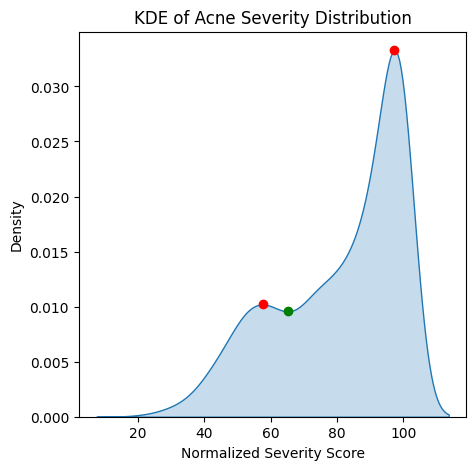

Do you want to view the data? Type Yes or No. Yes


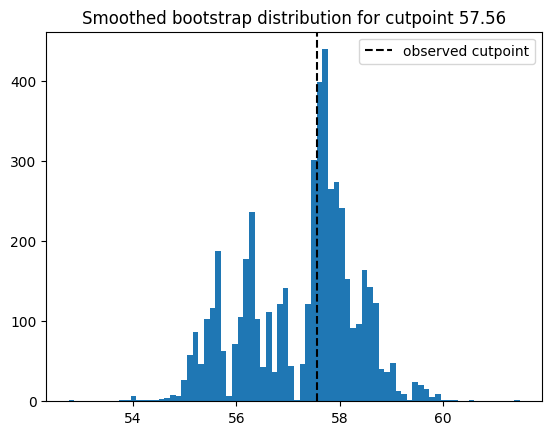

Cutpoint=57.5590, 95% CI=(55.1612,59.0271), MOE=1.9330


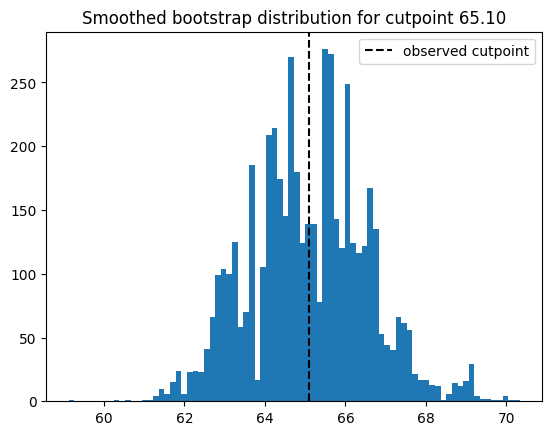

Cutpoint=65.1014, 95% CI=(62.4034,67.9996), MOE=2.7981


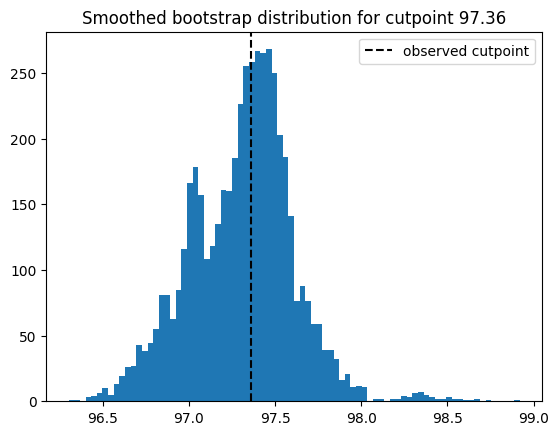

Cutpoint=97.3580, 95% CI=(96.7055,97.8713), MOE=0.5829


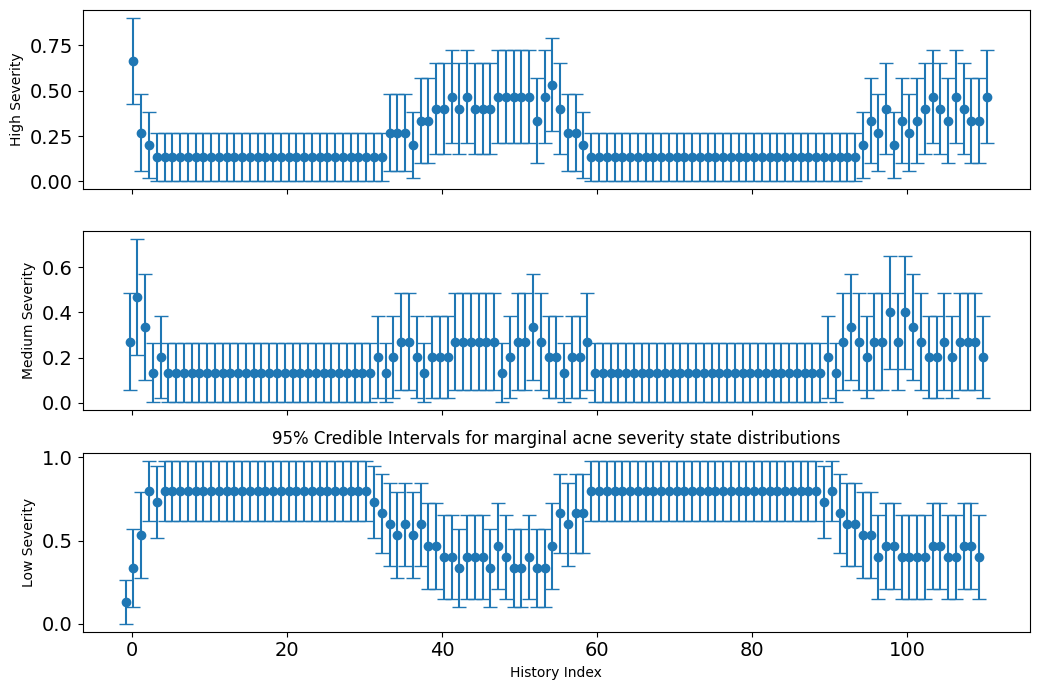

/Users/nathaniel/acneBayesModel/src/acne_model/data_viz.py:555: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right')


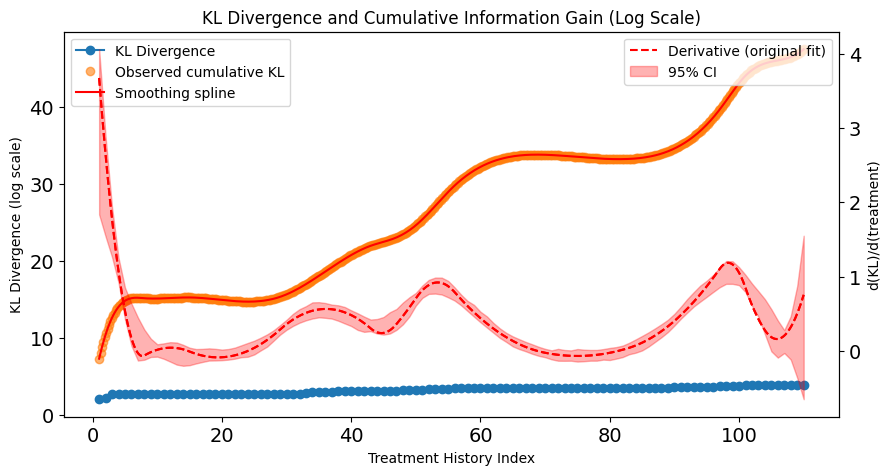

<Figure size 640x480 with 0 Axes>

initial parameters {'r_growth': 0.5, 'K_CC': 1.0, 'k_antibiotics': 0.2, 'k_sebum': 0.01, 'I_bacterial_induction': 0.15, 'I_decay_tstd': 0.35, 'I_baseline_decay': 0.3, 'r_I_production': 0.1, 'r_cream_clean': 0.125, 'noise': 0.01, 'w_sigma': 0.3, 'm_sigma': 0.5}
converged model parameters {'r_growth': np.float64(0.9999999999999998), 'I_bacterial_induction': np.float64(0.23507880642851897), 'I_decay_tstd': np.float64(0.09210340871976182), 'I_baseline_decay': np.float64(0.09210340871976185), 'k_sebum': np.float64(0.18420681743952363), 'k_antibiotics': np.float64(0.18420681743952363), 'r_cream_clean': np.float64(0.20627158503577944), 'K_CC': 1.0}


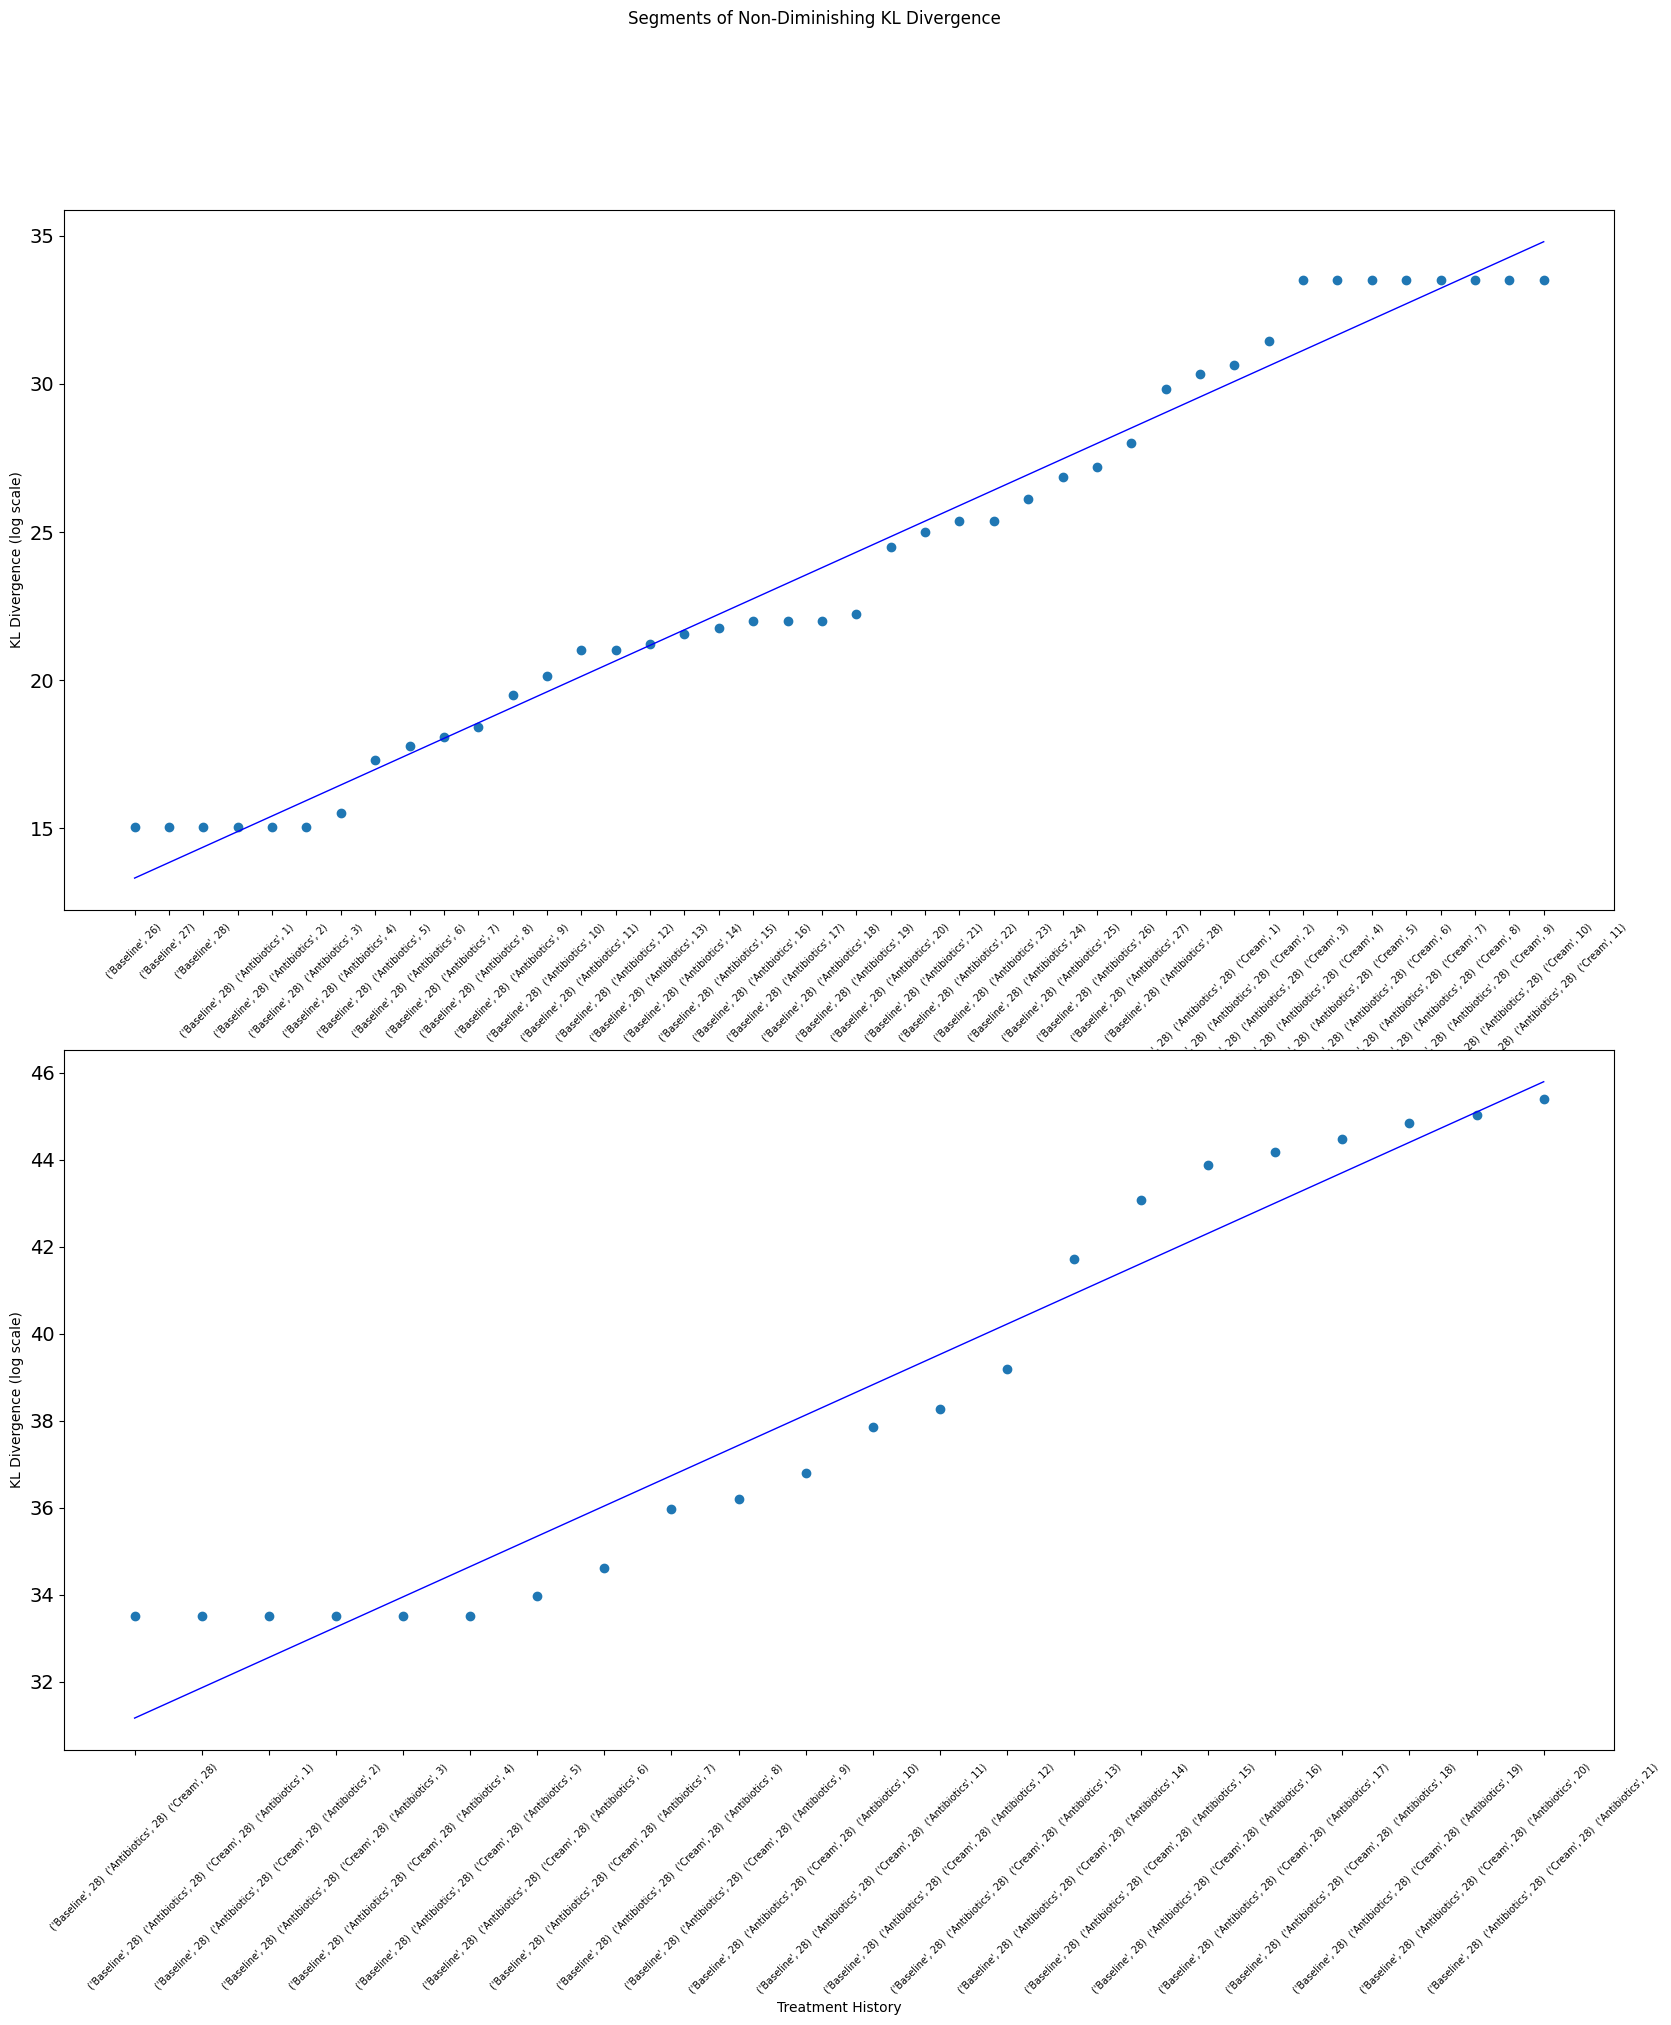

In [36]:
from acne_model.raw_data_analysis import data_parsing
from acne_model.data_viz import data_visualization

def main(this_raw_data_name, json_name):
    data_returns = data_parsing(this_raw_data_name)
    #this_data_visualization = data_visualization(data_returns[1], data_returns[0], data_returns[4], data_returns[3])
    these_ranges = data_returns[3]
    these_averages = data_returns[5]
    these_dirichlets = data_returns[6]

    view_plots = False
    user_input = input("Do you want to view the data? Type Yes or No.")
    
    if user_input == "Yes":
         view_plots = True
    if view_plots:
        
        this_data_visualization = data_visualization(data_returns[1], data_returns[0], data_returns[4], data_returns[3])
    if not view_plots:
        print("Ok, going on to modeling.")
    
    
    
    with open(json_name, "r") as icgs:
        initial_constant_guesses = json.load(icgs)
        this_model_config = {"scoring": np.random.randn(3, 3) * 0.02,
                        #column order: low severity change, medium, high. row order: #bacteria, inflammation, sebum.
    "biases": [0, 0, 0],
    "Q": np.eye(3) * (initial_constant_guesses["w_sigma"]**2),
    "R": np.eye(3) * (initial_constant_guesses["m_sigma"]**2)

}
           
    #reparameterization included now
    this_built_model = model_building(data_returns[1], reparameterize(initial_constant_guesses), these_dirichlets, these_averages, this_model_config)  
    

#retrieving Acne04 dataset from Kaggle source (local download on machine)
this_raw_data_name = "sim_acne.csv"
if __name__ == "__main__":
    main(this_raw_data_name, "initial_constants.json")

In [37]:
def fit_piecewise_regression_and_plot_unused(points, splits):
    """This function actually splits a given array (here, cumulative KL divergence) into seperate regression models,
    using splits to partition the array and then fit a linear regression model to each one.
    It then calls plot_piecewise_regression_segments to plot the segments over the cumulative KL divergence Curve. Unused in this version."""
    split_points_and_indices = [(points[split[0]:split[1]+1], split) for split in splits]
    linear_model = LinearRegression()
    consecutive_models = [LinearRegression().fit(np.arange(len(one_split_points[0])).reshape(-1, 1),one_split_points[0].reshape(-1, 1))for one_split_points in split_points_and_indices]

    slopes = [which_model.coef_[0] for which_model in consecutive_models]
    